# Neural Image Compression # 

Using local Data to test functionality with a few WSIs


## Imports ##

In [1]:
# Import NIC to python path
import sys
nic_dir = '/mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/code/neural-image-compression-private'
sys.path.append(nic_dir +'/source')
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from tqdm import tqdm
import os, shutil
from os.path import join, dirname, exists
import keras

Using TensorFlow backend.


## Data ##

To demonstrate the functionality of NIC, we will need a set of whole-slide images (WSIs) with their respective slide-level labels. In this case, we will use the WSIs that can be found using the following pattern:

These data was already reorganized, it is, all the tiff files are contained in one folder for each class. 

These are a small version of the TCGA dataset:

`/mnt/netcache/pathology/archives/lung/TCGA_LUAD/images_diagnostic`

`/mnt/netcache/pathology/archives/lung/TCGA_LUSC/images_diagnostic`



The data we are going to use is only the **diagnostic** data and no the **tissue** data. The mask are already given, but we will have to implementa script to create this masks that filter out the background.

Mask can be found at :

`/mnt/netcache/pathology/archives/lung/TCGA_LUAD/tissue_masks_diagnostic`

`/mnt/netcache/pathology/archives/lung/TCGA_LUSC/tissue_masks_diagnostic`


Because there is no slide-level csv file, we have to create one, this will be created after once we get the featurized wsi. FIle should be located at  from:

`E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\data\slide_original_list_tcga.csv`


In [2]:
# Creates csv from original data

# project and data directories
root_dir=  '/mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction'
data_dir = r'/mnt/netcache/pathology/archives/lung'

# wsi directories
dir_luad_wsi = os.path.join(data_dir, 'TCGA_LUAD', 'wsi_diagnostic_tif')
dir_lusc_wsi = os.path.join(data_dir, 'TCGA_LUSC', 'wsi_diagnostic_tif')
dir_luad_wsi_mask = os.path.join(data_dir, 'TCGA_LUAD', 'tissue_masks_diagnostic')
dir_lusc_wsi_mask = os.path.join(data_dir, 'TCGA_LUSC', 'tissue_masks_diagnostic')

# compressed image directories
vectorized_luad_dir = join(root_dir, 'results', 'tcga_luad', 'vectorized')
vectorized_lusc_dir = join(root_dir, 'results', 'tcga_lusc', 'vectorized')
featurized_luad_dir = join(root_dir, 'results', 'tcga_luad', 'featurized', 'no_augmentations')
featurized_lusc_dir = join(root_dir, 'results', 'tcga_lusc', 'featurized', 'no_augmentations')

# results directory 
result_dir = join(root_dir, 'results', 'model')  # store the results from trained model
gradcam_dir = join(result_dir, 'gradcam')        # store gradcam results

# Set paths
model_path = './neural-image-compression-private/models/encoders_patches_pathology/encoder_bigan.h5'
csv_train = os.path.join(root_dir, 'data', 'train_slide_list_tcga.csv')
csv_val = os.path.join(root_dir, 'data', 'validation_slide_list_tcga.csv')
csv_test = os.path.join(root_dir, 'data', 'test_slide_list_tcga.csv')

# csv paths
csv_path_wsi =  os.path.join(root_dir, 'data', 'slide_original_list_tcga.csv')
csv_path_compressed_wsi =  os.path.join(root_dir, 'data', 'slide_compressed_list_tcga.csv')

cache_dir = None  # used to store local copies of files during I/O operations (useful in cluster

## 0. Preprocessing

We need to create a csv file to point out the data.

In [3]:
from preprocessing import create_csv

print('Creating main csv data files from original data...')
create_csv(dir_luad_wsi, dir_lusc_wsi, csv_path_wsi, '.tif')

# read files to check shapes
df = pd.read_csv(csv_path_wsi)
print(f'Files were read with shapes: {df.shape}')
df.head()

100%|██████████| 531/531 [00:00<00:00, 141596.76it/s]

Creating main csv data files from original data...



100%|██████████| 506/506 [00:00<00:00, 160976.78it/s]


Csv file sucessfully exported!
Files were read with shapes: (1037, 2)


,slide_id,label
0,TCGA-05-4244-01Z-00-DX1,1
1,TCGA-05-4245-01Z-00-DX1,1
2,TCGA-05-4249-01Z-00-DX1,1
3,TCGA-05-4250-01Z-00-DX1,1
4,TCGA-05-4382-01Z-00-DX1,1


## 1. Encoder network ##

To perform NIC, we will need an encoder network to transform small image patches into embedding vectors. According to the paper, BiGAN produces the best unsupervised encoder and it is the one we will train here.

Alternatively, a collection of pretrained encoders (the one used in the NIC paper) can be found in 

`./models/encoders_patches_pathology/*.h5`

Remember that these pretrained encoders accept 128x128x3 patches taken at 0.5 um/px resolution (often level 1), except for the BiGAN model that takes 64x64x3 at 1 um/px (often level 2).



In order to train the BiGAN model, we will first extract patches from the slides in the `encoder` partition. We will sample 10K patches per slide, producing ~260K patches in total. We select 96x96 patches to perform crop augmentation during training later.

In [4]:
# # Dont run this we, will train later the encoder but not now. 

# from source.extract_patches import create_patch_dataset

# patches_npy_path = join(root_dir, 'results', 'patches', 'training.npy')

# # Extracts patches from whole-slide images and store them in a numpy array file
# create_patch_dataset(
#     input_dir=slide_dir,
#     csv_path=csv_path,
#     partition_tag='encoder',
#     output_path=patches_npy_path,
#     image_level=2,
#     patch_size=96,
#     n_patches_per_image=10000,
#     cache_dir=join(cache_dir, 'patches')
# )

Once we have extracted the patches, we can proceed to train the BiGAN model. We will use the hyper-parameters described in the NIC paper. 

In [5]:
# from source.train_bigan_model import BiganModel

# model_bigan_dir = join(root_dir, 'results', 'encoders', 'bigan', 'rotterdam1_96_noaug', '0.0001')

# # Trains BiGAN
# bigan = BiganModel(
#     latent_dim=128,
#     n_filters=128,
#     lr=0.0001,
#     patch_size=64,
# )
# bigan.train(
#     x_path=patches_npy_path,
#     output_dir=model_bigan_dir,
#     epochs=400000,
#     batch_size=64,
#     sample_interval=1000,
#     save_models_on_epoch=True
# )

Beware that training this model is highly unstable, thus it can fail or collapse with ease. If this happens, restart the training. Selecting a checkpoint model is a manual procedure: check the generated images and loss values and avoid abnormal results. 

## 2. Compress images ##

Once we have a trained encoder, we can proceed with the WSI compression. I recommend running several `IDLE` instances of the following code in the cluster to speed up the lenghty process.

Before the actual compression, we need to vectorize the WSIs. This process extracts all non-background patches from the slide and store them in numpy array format for quick access. In this case, we will read 64x64 patches at 1 um/px resolution (level 2).

In [4]:
# Vectorize LUAD WSIs
from vectorize_wsi import vectorize_images

vectorize_images(
    input_dir=dir_luad_wsi,
    mask_dir=dir_luad_wsi_mask, 
    output_dir=vectorized_luad_dir, 
    cache_dir=cache_dir, 
    image_level=2, 
    patch_size=128
    )

Already existing file TCGA-05-4244-01Z-00-DX1 - 530 images left
Already existing file TCGA-05-4245-01Z-00-DX1 - 529 images left
Already existing file TCGA-05-4249-01Z-00-DX1 - 528 images left
Already existing file TCGA-05-4250-01Z-00-DX1 - 527 images left
Already existing file TCGA-05-4382-01Z-00-DX1 - 526 images left
Already existing file TCGA-05-4395-01Z-00-DX1 - 525 images left
Already existing file TCGA-05-4396-01Z-00-DX1 - 524 images left
Already existing file TCGA-05-4397-01Z-00-DX1 - 523 images left
Already existing file TCGA-05-4398-01Z-00-DX1 - 522 images left
Already existing file TCGA-05-4402-01Z-00-DX1 - 521 images left
Already existing file TCGA-05-4403-01Z-00-DX1 - 520 images left
Already existing file TCGA-05-4405-01Z-00-DX1 - 519 images left
Already existing file TCGA-05-4415-01Z-00-DX1 - 518 images left
Already existing file TCGA-05-4417-01Z-00-DX1 - 517 images left
Already existing file TCGA-05-4418-01Z-00-DX1 - 516 images left
Already existing file TCGA-05-4420-01Z-0

Already existing file TCGA-50-6591-01Z-00-DX1 - 345 images left
Already existing file TCGA-50-6593-01Z-00-DX1 - 344 images left
Already existing file TCGA-50-6594-01Z-00-DX1 - 343 images left
Already existing file TCGA-50-6597-01Z-00-DX1 - 342 images left
Already existing file TCGA-50-6673-01Z-00-DX1 - 341 images left
Already existing file TCGA-50-7109-01Z-00-DX1 - 340 images left
Already existing file TCGA-50-8457-01Z-00-DX1 - 339 images left
Already existing file TCGA-50-8459-01Z-00-DX1 - 338 images left
Already existing file TCGA-53-7624-01Z-00-DX1 - 337 images left
Already existing file TCGA-53-7626-01Z-00-DX1 - 336 images left
Already existing file TCGA-53-7813-01Z-00-DX1 - 335 images left
Already existing file TCGA-53-A4EZ-01Z-00-DX1 - 334 images left
Already existing file TCGA-55-1592-01Z-00-DX1 - 333 images left
Already existing file TCGA-55-1594-01Z-00-DX1 - 332 images left
Already existing file TCGA-55-1595-01Z-00-DX1 - 331 images left
Already existing file TCGA-55-1596-01Z-0

Already existing file TCGA-75-7031-01Z-00-DX1 - 168 images left
Already existing file TCGA-78-7145-01Z-00-DX1 - 167 images left
Already existing file TCGA-78-7146-01Z-00-DX1 - 166 images left
Already existing file TCGA-78-7147-01Z-00-DX1 - 165 images left
Already existing file TCGA-78-7148-01Z-00-DX1 - 164 images left
Already existing file TCGA-78-7149-01Z-00-DX1 - 163 images left
Already existing file TCGA-78-7150-01Z-00-DX1 - 162 images left
Already existing file TCGA-78-7152-01Z-00-DX1 - 161 images left
Already existing file TCGA-78-7153-01Z-00-DX1 - 160 images left
Already existing file TCGA-78-7154-01Z-00-DX1 - 159 images left
Already existing file TCGA-78-7155-01Z-00-DX1 - 158 images left
Already existing file TCGA-78-7156-01Z-00-DX1 - 157 images left
Already existing file TCGA-78-7158-01Z-00-DX1 - 156 images left
Already existing file TCGA-78-7159-01Z-00-DX1 - 155 images left
Already existing file TCGA-78-7160-01Z-00-DX1 - 154 images left
Already existing file TCGA-78-7161-01Z-0

In [5]:
# Vectorize LUSC WSIs

vectorize_images(
    input_dir=dir_lusc_wsi,
    mask_dir=dir_lusc_wsi_mask, 
    output_dir=vectorized_lusc_dir, 
    cache_dir=cache_dir, 
    image_level=2, 
    patch_size=128
    )

Already existing file TCGA-18-3406-01Z-00-DX1 - 505 images left
Already existing file TCGA-18-3407-01Z-00-DX1 - 504 images left
Already existing file TCGA-18-3408-01Z-00-DX1 - 503 images left
Already existing file TCGA-18-3409-01Z-00-DX1 - 502 images left
Already existing file TCGA-18-3410-01Z-00-DX1 - 501 images left
Already existing file TCGA-18-3411-01Z-00-DX1 - 500 images left
Already existing file TCGA-18-3412-01Z-00-DX1 - 499 images left
Already existing file TCGA-18-3414-01Z-00-DX1 - 498 images left
Already existing file TCGA-18-3415-01Z-00-DX1 - 497 images left
Already existing file TCGA-18-3416-01Z-00-DX1 - 496 images left
Already existing file TCGA-18-3417-01Z-00-DX1 - 495 images left
Already existing file TCGA-18-3419-01Z-00-DX1 - 494 images left
Already existing file TCGA-18-3421-01Z-00-DX1 - 493 images left
Already existing file TCGA-18-4083-01Z-00-DX1 - 492 images left
Already existing file TCGA-18-4086-01Z-00-DX1 - 491 images left
Already existing file TCGA-18-4721-01Z-0

Already existing file TCGA-46-6025-01Z-00-DX1 - 315 images left
Already existing file TCGA-46-6026-01Z-00-DX1 - 314 images left
Already existing file TCGA-51-4079-01Z-00-DX1 - 313 images left
Already existing file TCGA-51-4080-01Z-00-DX1 - 312 images left
Already existing file TCGA-51-4081-01Z-00-DX1 - 311 images left
Already existing file TCGA-51-6867-01Z-00-DX1 - 310 images left
Already existing file TCGA-52-7622-01Z-00-DX1 - 309 images left
Already existing file TCGA-52-7809-01Z-00-DX1 - 308 images left
Already existing file TCGA-52-7810-01Z-00-DX1 - 307 images left
Already existing file TCGA-52-7811-01Z-00-DX1 - 306 images left
Already existing file TCGA-52-7812-01Z-00-DX1 - 305 images left
Already existing file TCGA-56-1622-01Z-00-DX1 - 304 images left
Already existing file TCGA-56-5897-01Z-00-DX1 - 303 images left
Already existing file TCGA-56-5898-01Z-00-DX1 - 302 images left
Already existing file TCGA-56-6545-01Z-00-DX1 - 301 images left
Already existing file TCGA-56-7221-01Z-0

Already existing file TCGA-77-A5GA-01Z-00-DX1 - 124 images left
Already existing file TCGA-77-A5GB-01Z-00-DX1 - 123 images left
Already existing file TCGA-77-A5GF-01Z-00-DX1 - 122 images left
Already existing file TCGA-77-A5GH-01Z-00-DX1 - 121 images left
Already existing file TCGA-85-6175-01Z-00-DX1 - 120 images left
Already existing file TCGA-85-6560-01Z-00-DX1 - 119 images left
Already existing file TCGA-85-6561-01Z-00-DX1 - 118 images left
Already existing file TCGA-85-6798-01Z-00-DX1 - 117 images left
Already existing file TCGA-85-7696-01Z-00-DX1 - 116 images left
Already existing file TCGA-85-7697-01Z-00-DX1 - 115 images left
Already existing file TCGA-85-7698-01Z-00-DX1 - 114 images left
Already existing file TCGA-85-7699-01Z-00-DX1 - 113 images left
Already existing file TCGA-85-7710-01Z-00-DX1 - 112 images left
Already existing file TCGA-85-7843-01Z-00-DX1 - 111 images left
Already existing file TCGA-85-7844-01Z-00-DX1 - 110 images left
Already existing file TCGA-85-7950-01Z-0

Now we can compress the WSIs. Each WSI (vectorized file) will be processed 8 times due to WSI-level augmentation (rotation and flip). We will use an existing pretrained encoder from the NIC paper.

In [6]:
# Featurize images
from featurize_wsi import featurize_images

# Featurize LUAD data
featurize_images(
    input_dir=vectorized_luad_dir,
    model_path=model_path, 
    output_dir=featurized_luad_dir, 
    batch_size=32
    )

Already existing file TCGA-05-4244-01Z-00-DX1_{item} - 530 images left
Already existing file TCGA-05-4245-01Z-00-DX1_{item} - 529 images left
Already existing file TCGA-05-4249-01Z-00-DX1_{item} - 528 images left
Already existing file TCGA-05-4250-01Z-00-DX1_{item} - 527 images left
Already existing file TCGA-05-4382-01Z-00-DX1_{item} - 526 images left
Already existing file TCGA-05-4395-01Z-00-DX1_{item} - 525 images left
Already existing file TCGA-05-4396-01Z-00-DX1_{item} - 524 images left
Already existing file TCGA-05-4397-01Z-00-DX1_{item} - 523 images left
Already existing file TCGA-05-4398-01Z-00-DX1_{item} - 522 images left
Already existing file TCGA-05-4402-01Z-00-DX1_{item} - 521 images left
Already existing file TCGA-05-4403-01Z-00-DX1_{item} - 520 images left
Already existing file TCGA-05-4405-01Z-00-DX1_{item} - 519 images left
Already existing file TCGA-05-4415-01Z-00-DX1_{item} - 518 images left
Already existing file TCGA-05-4417-01Z-00-DX1_{item} - 517 images left
Alread

Already existing file TCGA-49-4514-01Z-00-DX2_{item} - 396 images left
Already existing file TCGA-49-4514-01Z-00-DX3_{item} - 395 images left
Already existing file TCGA-49-4514-01Z-00-DX4_{item} - 394 images left
Already existing file TCGA-49-6742-01Z-00-DX1_{item} - 393 images left
Already existing file TCGA-49-6742-01Z-00-DX2_{item} - 392 images left
Already existing file TCGA-49-6742-01Z-00-DX3_{item} - 391 images left
Already existing file TCGA-49-6742-01Z-00-DX4_{item} - 390 images left
Already existing file TCGA-49-6742-01Z-00-DX5_{item} - 389 images left
Already existing file TCGA-49-6743-01Z-00-DX1_{item} - 388 images left
Already existing file TCGA-49-6743-01Z-00-DX2_{item} - 387 images left
Already existing file TCGA-49-6743-01Z-00-DX3_{item} - 386 images left
Already existing file TCGA-49-6743-01Z-00-DX4_{item} - 385 images left
Already existing file TCGA-49-6744-01Z-00-DX1_{item} - 384 images left
Already existing file TCGA-49-6744-01Z-00-DX2_{item} - 383 images left
Alread

Already existing file TCGA-64-1679-01Z-00-DX1_{item} - 230 images left
Already existing file TCGA-64-1680-01Z-00-DX1_{item} - 229 images left
Already existing file TCGA-64-1681-01Z-00-DX1_{item} - 228 images left
Already existing file TCGA-64-5774-01Z-00-DX1_{item} - 227 images left
Already existing file TCGA-64-5775-01Z-00-DX1_{item} - 226 images left
Already existing file TCGA-64-5778-01Z-00-DX1_{item} - 225 images left
Already existing file TCGA-64-5779-01Z-00-DX1_{item} - 224 images left
Already existing file TCGA-64-5781-01Z-00-DX1_{item} - 223 images left
Already existing file TCGA-64-5815-01Z-00-DX1_{item} - 222 images left
Already existing file TCGA-67-3770-01Z-00-DX1_{item} - 221 images left
Already existing file TCGA-67-3771-01Z-00-DX1_{item} - 220 images left
Already existing file TCGA-67-3772-01Z-00-DX1_{item} - 219 images left
Already existing file TCGA-67-3773-01Z-00-DX1_{item} - 218 images left
Already existing file TCGA-67-3774-01Z-00-DX1_{item} - 217 images left
Alread

Already existing file TCGA-97-A4M3-01Z-00-DX1_{item} - 59 images left
Already existing file TCGA-97-A4M5-01Z-00-DX1_{item} - 58 images left
Already existing file TCGA-97-A4M6-01Z-00-DX1_{item} - 57 images left
Already existing file TCGA-97-A4M7-01Z-00-DX1_{item} - 56 images left
Already existing file TCGA-97-A4M7-01Z-00-DX2_{item} - 55 images left
Already existing file TCGA-99-7458-01Z-00-DX1_{item} - 54 images left
Already existing file TCGA-99-8025-01Z-00-DX1_{item} - 53 images left
Already existing file TCGA-99-8028-01Z-00-DX1_{item} - 52 images left
Already existing file TCGA-99-8032-01Z-00-DX1_{item} - 51 images left
Already existing file TCGA-99-8033-01Z-00-DX1_{item} - 50 images left
Already existing file TCGA-99-AA5R-01Z-00-DX1_{item} - 49 images left
Already existing file TCGA-J2-8192-01Z-00-DX1_{item} - 48 images left
Already existing file TCGA-J2-8194-01Z-00-DX1_{item} - 47 images left
Already existing file TCGA-J2-A4AD-01Z-00-DX1_{item} - 46 images left
Already existing fil

In [7]:
# Featurize LUSC data
featurize_images(
    input_dir=vectorized_lusc_dir,
    model_path=model_path, 
    output_dir=featurized_lusc_dir, 
    batch_size=32
    )

Already existing file TCGA-18-3406-01Z-00-DX1_{item} - 505 images left
Already existing file TCGA-18-3407-01Z-00-DX1_{item} - 504 images left
Already existing file TCGA-18-3408-01Z-00-DX1_{item} - 503 images left
Already existing file TCGA-18-3409-01Z-00-DX1_{item} - 502 images left
Already existing file TCGA-18-3410-01Z-00-DX1_{item} - 501 images left
Already existing file TCGA-18-3411-01Z-00-DX1_{item} - 500 images left
Already existing file TCGA-18-3412-01Z-00-DX1_{item} - 499 images left
Already existing file TCGA-18-3414-01Z-00-DX1_{item} - 498 images left
Already existing file TCGA-18-3415-01Z-00-DX1_{item} - 497 images left
Already existing file TCGA-18-3416-01Z-00-DX1_{item} - 496 images left
Already existing file TCGA-18-3417-01Z-00-DX1_{item} - 495 images left
Already existing file TCGA-18-3419-01Z-00-DX1_{item} - 494 images left
Already existing file TCGA-18-3421-01Z-00-DX1_{item} - 493 images left
Already existing file TCGA-18-4083-01Z-00-DX1_{item} - 492 images left
Alread

Already existing file TCGA-43-A56U-01Z-00-DX1_{item} - 322 images left
Already existing file TCGA-43-A56V-01Z-00-DX1_{item} - 321 images left
Already existing file TCGA-46-3765-01Z-00-DX1_{item} - 320 images left
Already existing file TCGA-46-3766-01Z-00-DX1_{item} - 319 images left
Already existing file TCGA-46-3767-01Z-00-DX1_{item} - 318 images left
Already existing file TCGA-46-3768-01Z-00-DX1_{item} - 317 images left
Already existing file TCGA-46-3769-01Z-00-DX1_{item} - 316 images left
Already existing file TCGA-46-6025-01Z-00-DX1_{item} - 315 images left
Already existing file TCGA-46-6026-01Z-00-DX1_{item} - 314 images left
Already existing file TCGA-51-4079-01Z-00-DX1_{item} - 313 images left
Already existing file TCGA-51-4080-01Z-00-DX1_{item} - 312 images left
Already existing file TCGA-51-4081-01Z-00-DX1_{item} - 311 images left
Already existing file TCGA-51-6867-01Z-00-DX1_{item} - 310 images left
Already existing file TCGA-52-7622-01Z-00-DX1_{item} - 309 images left
Alread

Already existing file TCGA-77-8148-01Z-00-DX1_{item} - 135 images left
Already existing file TCGA-77-8150-01Z-00-DX1_{item} - 134 images left
Already existing file TCGA-77-8153-01Z-00-DX1_{item} - 133 images left
Already existing file TCGA-77-8154-01Z-00-DX1_{item} - 132 images left
Already existing file TCGA-77-8156-01Z-00-DX1_{item} - 131 images left
Already existing file TCGA-77-A5FZ-01Z-00-DX1_{item} - 130 images left
Already existing file TCGA-77-A5G1-01Z-00-DX1_{item} - 129 images left
Already existing file TCGA-77-A5G3-01Z-00-DX1_{item} - 128 images left
Already existing file TCGA-77-A5G6-01Z-00-DX1_{item} - 127 images left
Already existing file TCGA-77-A5G7-01Z-00-DX1_{item} - 126 images left
Already existing file TCGA-77-A5G8-01Z-00-DX1_{item} - 125 images left
Already existing file TCGA-77-A5GA-01Z-00-DX1_{item} - 124 images left
Already existing file TCGA-77-A5GB-01Z-00-DX1_{item} - 123 images left
Already existing file TCGA-77-A5GF-01Z-00-DX1_{item} - 122 images left
Alread

## 3. Train CNN on compressed images ##

Once we have compressed the WSIs, we can proceed with the CNN classifier. In this example, we will train a classifier targeting the binary label `HGP_SL` found in the CSV file. We will be training 4 models using cross-validation: in each fold, we will use 2 data partitions for training, 1 for validation and 1 for testing. At the end of model training, we perform inference on the test set, compute metrics, and run GradCAM on the images.



### 3.1 Creat train/val/test csv splits

In [13]:
# Copy data
#os.system('mkdir ./featurized_tcga_luad/')
#os.system('mkdir ~/home/user/data/featurized_tcga_lusc/')
#os.system('cp /mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/results/tcga_luad/featurized/no_augmentations/* ./tcga_luad')
#os.system('cp /mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/results/tcga_lusc/featurized/no_augmentations/* ./tcga_lusc')

256

In [17]:
os.system('mkdir /home/user/data/featurized_tcga_luad/')

256

In [8]:
# Update directories 

featurized_luad_dir = '/home/user/data/featurized_tcga_luad'
featurized_lusc_dir = '/home/user/data/featurized_tcga_lusc'

In [9]:
from preprocessing import generate_csv_files 

print('Creating compressed wsi csv file ...')
create_csv(featurized_luad_dir, featurized_lusc_dir, csv_path_compressed_wsi)

print('Creating split train/validation/test csv files with no augmentations ...')
generate_csv_files(csv_path_compressed_wsi, csv_train, csv_val, csv_test, test_size=0.2, validation_size = 0.3)

# read files to check shapes
df = pd.read_csv(csv_train);  df2 = pd.read_csv(csv_val);   df3 = pd.read_csv(csv_test)
print(f'Files were read with shapes: Training: {df.shape}, Validation {df2.shape}, Testing {df3.shape}')
print(f'Total files: Files were read with shapes: {df.shape[0]+df2.shape[0]+df3.shape[0]}')
df.head()

Creating compressed wsi csv file ...


FileNotFoundError: [Errno 2] No such file or directory: '/home/user/data/featurized_tcga_luad'

In [10]:
from model_training import train_wsi_classifier, eval_model, compute_metrics
from utils import check_file_exists

def train_model(featurized_dir, csv_path, fold_n, output_dir, cache_dir, batch_size=16, epochs=32,
                images_dir=None, vectorized_dir=None, lr=1e-2, patience=4, delete_folder=False,
                occlusion_augmentation=False, elastic_augmentation=False, shuffle_augmentation=None):
    """
    Trains a CNN using compressed whole-slide images.

    :param featurized_dir: folder containing the compressed (featurized) images.
    :param csv_path: list of slides with labels.
    :param fold_n: fold determining which data partitions to use for training, validation and testing.
    :param output_dir: destination folder to store results.
    :param cache_dir: folder to store compressed images temporarily for fast access.
    :param batch_size: number of samples to train with in one-go.
    :return: nothing.
    """
    
    # Delete folder and subfolders if exists
    if delete_folder: 
        if exists(result_dir):  shutil.rmtree(result_dir)
            
    # Train CNN
    train_wsi_classifier(
        data_dir=featurized_dir,
        csv_path=csv_path,
        partitions=None,
        crop_size=400,
        output_dir=output_dir,
        output_units=2,
        cache_dir=cache_dir,
        n_epochs=epochs,
        batch_size=batch_size,
        lr=lr,
        code_size=128,
        workers=1,
        train_step_multiplier=1,
        val_step_multiplier=0.5,
        keep_data_training=1,
        keep_data_validation=1,
        patience=patience,
        occlusion_augmentation=occlusion_augmentation,
        elastic_augmentation=elastic_augmentation,
        shuffle_augmentation=shuffle_augmentation
    )  

    # Evaluate CNN 
    
    # Get compressed wsi directories with csv test file
    data_config = featurized_dir
    data_config['csv_path'] = csv_path['csv_test']
    
    eval_model(
        model_path=join(output_dir, 'checkpoint.h5'),
        data_config=data_config,
        crop_size=400,
        output_path=join(output_dir, 'eval', 'preds.csv'),
        cache_dir=None,
        batch_size=batch_size,
        keep_data=1
    )

    # Metrics
    try:
        compute_metrics(
            input_path=join(output_dir, 'eval', 'preds.csv'),
            output_dir=join(output_dir, 'eval')
        )
    except Exception as e:
        print('Failed to compute metrics. Exception: {e}'.format(e=e), flush=True)

#     # Apply GradCAM analysis to CNN
#     gradcam_on_dataset(
#         featurized_dir=featurized_dir,
#         csv_path=csv_path,
#         model_path=join(output_dir, 'checkpoint.h5'),
#         partitions=folds[fold_n]['test'],
#         layer_name='separable_conv2d_1',
#         output_unit=1,
#         custom_objects=None,
#         cache_dir=cache_dir,
#         images_dir=images_dir,
#         vectorized_dir=vectorized_dir
#     )

Copy data before training to cluster instance

In [ ]:
# Train CNN

#selected_fold = 0

featurized_dir = {'data_dir_luad': featurized_luad_dir, 'data_dir_lusc': featurized_lusc_dir}
csv_path = {'csv_train': csv_train, 'csv_val': csv_val, 'csv_test': csv_test}

train_model(
    featurized_dir=featurized_dir,
    csv_path=csv_path,
    fold_n=0, 
    output_dir=result_dir,
    cache_dir=None,
    batch_size =12,
    epochs=1,
    delete_folder=True,
    occlusion_augmentation=False,
    lr=1e-2,
    patience=4,
    elastic_augmentation=False,
    images_dir=None,  # required for GradCAM
    vectorized_dir=None,  # required for GradCAM
    shuffle_augmentation=None
)

Loading training set ...
FeaturizedWsiGenerator data config: {'data_dir_luad': '/mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/results/tcga_luad/featurized/no_augmentations', 'data_dir_lusc': '/mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/results/tcga_lusc/featurized/no_augmentations', 'csv_path': '/mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/data/train_slide_list_tcga.csv'}
FeaturizedWsiGenerator using 580 samples and 49 batches, distributed in 306 positive and 274 negative samples.
Loading validation set ...
FeaturizedWsiSequence data config: {'data_dir_luad': '/mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/results/tcga_luad/featurized/no_augmentations', 'data_dir_lusc': '/mnt/netcache/pathology/projects/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/results

## Aplying GradCam

Here we get the folder separetely

In [12]:
def create_csv(data_dir, csv_path, ext='.png'):
    """
    Creates csv file from data folder

    Parameters
    ----------
    data_dir : data folder

    Output
    ----------
    csv file with labels as 1 and slide names

    Example: create_csv(featurized_luad_dir, csv_path)
    -----
    """

    files_class_1 = sorted([(os.path.basename(file)).split('.')[0] for file in tqdm(os.listdir(data_dir)) if file.endswith(ext)])
    labels1 = np.ones(len(files_class_1), dtype=np.int8)
    df1 = pd.DataFrame(list(zip(files_class_1, labels1)), columns=['slide_id', 'label'])
    df1.to_csv(csv_path, index=None, header=True)
    print('Csv file sucessfully exported!')

csv_path_luad_feat = join(data_dir, 'slide_list_featurized_luad.csv')
create_csv(featurized_luad_dir, csv_path_luad_feat)
pd.read_csv(csv_path_luad_feat)

100%|██████████| 30/30 [00:00<00:00, 29980.73it/s]


Csv file sucessfully exported!


,slide_id,label
0,TCGA-05-4244-01Z-00-DX1,1
1,TCGA-05-4245-01Z-00-DX1,1
2,TCGA-05-4249-01Z-00-DX1,1
3,TCGA-05-4250-01Z-00-DX1,1
4,TCGA-05-4382-01Z-00-DX1,1
5,TCGA-05-4395-01Z-00-DX1,1
6,TCGA-05-4396-01Z-00-DX1,1
7,TCGA-05-4397-01Z-00-DX1,1
8,TCGA-05-4398-01Z-00-DX1,1
9,TCGA-4B-A93V-01Z-00-DX1,1


In [13]:
# for layer in model.layers:
#     print(layer.name)

In [14]:
from gradcam_wsi import grad_cam_fn, gradcam_on_features, overlay_gradcam_heatmap
from gradcam_wsi import image_crop_from_wsi, overlay_gradcam_heatmap_bicolor
from nic.util_fns import cache_file
from data_processing import read_data
from keras import backend as K


csv_path = 'E:/pathology-weakly-supervised-lung-cancer-growth-pattern-prediction/data/slide_list_featurized_luad.csv'
model_path = join(result_dir, 'checkpoint.h5')

#############################
#This section will be adapted once gradcam is in a unified function
#############################
# GradCam for LUAD compressed images for now!!! This has to be modified to get for the whole dataset
images_dir =  dir_luad_wsi 
predict_two_output = True 
output_dir = join(result_dir, 'gradcam') if gradcam_dir is None else gradcam_dir
vectorized_dir = vectorized_luad_dir
#############################



#############################
# Function starts
#############################

if not exists(output_dir):
    os.makedirs(output_dir)
    
print('GradCAM in directory: {d} with content {c}'.format(
        d=output_dir,
        c=os.system("ls " + output_dir)
    ), flush=True)

# List features
data_config = {'data_dir_luad': featurized_luad_dir, 'data_dir_lusc': featurized_lusc_dir, 'csv_path': csv_path}
image_ids, paths, dm_paths, labels, features_ids = read_data(data_config, custom_augmentations=None)

# Load model
K.set_learning_phase(0)  # required to avoid bug "You must feed a value for placeholder tensor 'batch_normalization_1/keras_learning_phase' with dtype bool"
model = keras.models.load_model(model_path, custom_objects=None)

# get firt layer name 
layer_name=model.layers[1].name

# Load gradient function
gradient_function_0 = grad_cam_fn(model, 0, layer_name)

if predict_two_output:
    gradient_function_1 = grad_cam_fn(model, 1, layer_name)
else:
    gradient_function_1 = None

GradCAM in directory: E:\pathology-weakly-supervised-lung-cancer-growth-pattern-prediction\results\model\gradcam with content 0


In [15]:
# Analyze features
for i, (image_id, path, dm_path, label, features_id) in enumerate(zip(image_ids, paths, dm_paths, labels, features_ids)):

    try:
        print('Computing GradCAM on {filename} ... {i}/{n}'.format(
                filename=features_id, i=i+1, n=len(image_ids)), flush=True)

        output_npy_path0, output_png_path0 = gradcam_on_features(
            features_path=cache_file(path, cache_dir, overwrite=False),
            distance_map_path=cache_file(dm_path, cache_dir, overwrite=False),
            gradient_function=gradient_function_0,
            output_npy_path=join(output_dir, features_id + '_{unit}_{preds}_gradcam.npy'.format(unit=0, preds='{preds:0.3f}')),
            output_png_path=join(output_dir, features_id + '_{unit}_{preds}_gradcam.png'.format(unit=0, preds='{preds:0.3f}')),
        )

        if predict_two_output:
            output_npy_path1, output_png_path1 = gradcam_on_features(
                features_path=cache_file(path, cache_dir, overwrite=False),
                distance_map_path=cache_file(dm_path, cache_dir, overwrite=False),
                gradient_function=gradient_function_1,
                output_npy_path=join(output_dir, features_id + '_{unit}_{preds}_gradcam.npy'.format(unit=1, preds='{preds:0.3f}')),
                output_png_path=join(output_dir, features_id + '_{unit}_{preds}_gradcam.png'.format(unit=1, preds='{preds:0.3f}')),
            )
        
        if (images_dir is not None) and (vectorized_dir is not None):
                image_crop_from_wsi(
                    wsi_path=join(images_dir,  image_id + '.tif'),
                    vectorized_im_shape_path=join(vectorized_dir, image_id + '_im_shape.npy'),
                    distance_map_path=cache_file(dm_path, cache_dir, overwrite=False),
                    output_npy_path=join(output_dir, features_id + '_image.npy'),
                    output_png_path=join(output_dir, features_id + '_image.png'),
                    crop_size=400
                )
        
        overlay_gradcam_heatmap(
                    gradcam_npy_path=output_npy_path0,
                    image_npy_path=join(output_dir, features_id + '_image.npy'),
                    output_png_path=join(output_dir, features_id + '_{unit}_heatmap.png'.format(unit=0))
                )
        
        if predict_two_output:
                    overlay_gradcam_heatmap(
                        gradcam_npy_path=output_npy_path1,
                        image_npy_path=join(output_dir, features_id + '_image.npy'),
                        output_png_path=join(output_dir, features_id + '_{unit}_heatmap.png'.format(unit=1))
                    )

                    overlay_gradcam_heatmap_bicolor(
                        gradcam_npy_path1=output_npy_path0,
                        gradcam_npy_path2=output_npy_path1,
                        image_npy_path=join(output_dir, features_id + '_image.npy'),
                        output_png_path=join(output_dir, features_id + '_both_heatmap.png')
                    )
        
    except Exception as e:
        print('Failed to compute GradCAM on {f}. Exception: {e}'.format(f=path, e=e), flush=True)

Computing GradCAM on TCGA-05-4382-0 ... 1/10


D:\Users\Gabriel\Anaconda3\envs\tensorflow\lib\site-packages\scipy\ndimage\interpolation.py:611: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Computing GradCAM on TCGA-4B-A93V-0 ... 2/10
Computing GradCAM on TCGA-05-4395-0 ... 3/10
Computing GradCAM on TCGA-05-4244-0 ... 4/10
Computing GradCAM on TCGA-05-4250-0 ... 5/10
Computing GradCAM on TCGA-05-4397-0 ... 6/10
Computing GradCAM on TCGA-05-4396-0 ... 7/10
Computing GradCAM on TCGA-05-4249-0 ... 8/10
Computing GradCAM on TCGA-05-4245-0 ... 9/10
Computing GradCAM on TCGA-05-4398-0 ... 10/10


In [16]:
def plot_gradcam(gradcam_images):
    %matplotlib inline
    rows = 3; columns = 5;
    fig, axs = plt.subplots(rows,columns,figsize=(20,8))
    axs = axs.ravel()
    n_images = rows * columns

    for idx in range(n_images):
        img = plt.imread(gradcam_images[idx])
        if idx == 0: print(f'Images shape: {img.shape}')
        axs[idx].imshow(img)
        prefix = os.path.basename(gradcam_images[idx]).split('_')[0]
        subfix = os.path.basename(gradcam_images[idx]).split('_')[-1]
        axs[idx].set_title(prefix + '_' + subfix)
        axs[idx].set_xlabel(prefix + subfix)
        axs[idx].get_xaxis().set_visible(False)
        axs[idx].get_yaxis().set_visible(False)

Images shape: (400, 400, 4)


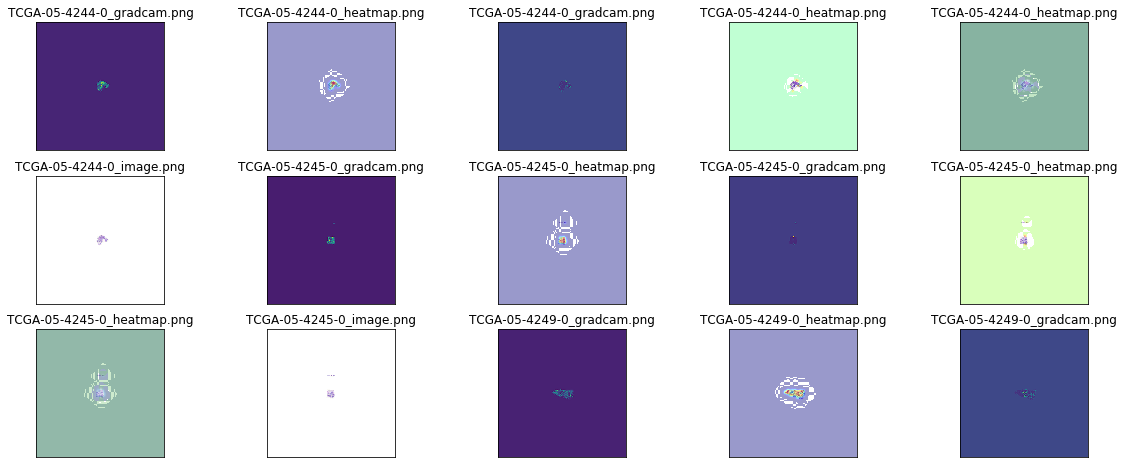

In [17]:
layer_name=model.layers[1].name
model_path = join(result_dir, 'checkpoint.h5')
predict_two_output = True 

# Get gradcam images
gradcam_images = sorted([os.path.join(gradcam_dir, f) for f in os.listdir(gradcam_dir) if f.endswith('.png')])

# Plot images
plot_gradcam(gradcam_images)